## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [1]:
import pandas as pd
import string 
import re
import nltk
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score 
from tabulate import tabulate
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/aryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aryan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load dataset

In [2]:
# read text file into pandas DataFrame
df = pd.read_csv("emails.txt", sep="\t", header=None, names=['label','text']) 
print(df)

     label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [3]:
# mapping ham --> 0 and spam --> 1
for i in df.index:
    if df['label'][i] == 'ham':
        df['label'][i] = 0
    else:
        df['label'][i] = 1

df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Preprocess data

In [4]:
df['token'] = ''
all_words = set()
stopwords = nltk.corpus.stopwords.words('english')
wordlem=nltk.WordNetLemmatizer()
for i in df.index:
    letter_list = []
    for j in range(len(df['text'][i])):
        letter = df['text'][i][j]
        if letter not in string.punctuation:
            letter_list.append(letter)

    text = "".join(letter_list)
    text = text.lower()
    text=re.sub(r'http\S+', 'website_link',text)
    text=re.sub(r"\S*@\S*\s?", 'email-tag',text)
    text = re.sub(re.compile('\W'), ' ', text)

    text = text.split()
    clean_text = []
    for j in range(len(text)):
        if text[j] not in stopwords and text[j].isalpha() and len(text[j])>1:   #the word should not be a stop word and should only contains alphabets and single letter words doesn't add any sense
            final_token = wordlem.lemmatize(text[j])
            clean_text.append(final_token)
            all_words.add(final_token)

    df['token'][i] = clean_text

df.head()

,label,text,token
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, g..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"


In [5]:
# calculating tf idf and creating vectors for each email  
idf = {}
for i in df.index:
    for token in df['token'][i]:
        idf[token] = 0

for i in df.index:
    tokens_encountered = set()
    for token in df['token'][i]:
        if token not in tokens_encountered:
            idf[token] += 1
        tokens_encountered.add(token)

total_docs = len(df)
df['tf-idf'] = ''
df['vector'] = ''

for i in df.index:
    tf = {}
    words = set()
    for token in df['token'][i]:
        tf[token] = 0
        words.add(token)

    for token in df['token'][i]:
        tf[token] += 1

    tf_idf = {}
    for token in words:
        tf_idf[token] = (math.log(1+tf[token])*math.log(total_docs/idf[token]))
    
    df['tf-idf'][i] = tf_idf

    # creating vectors
    vec = []
    for token in all_words:
        if token in words:
            vec.append(tf_idf[token])
        else:
            vec.append(0.0)

    df['vector'][i] = vec

df.head()

,label,text,token,tf-idf,vector
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, g...","{'world': 3.534460621103632, 'jurong': 5.97874...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]","{'joking': 4.7367944520422025, 'lar': 3.475849...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,...","{'fa': 8.714590540923492, 'cup': 4.45574745554...","[8.714590540923492, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,0,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]","{'early': 3.598488927511406, 'say': 4.28252420...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]","{'nah': 4.382717111171031, 'usf': 4.3166531287...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Split data

In [6]:
# splitting the data into train(80%) valid(10%) and test(10%)   --> using random state=42 by which both spam and ham emails will get distributed proportionately in the train-valid-test dataset 
x = df['tf-idf']
y = df['label']

x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.8,random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5,random_state=42)

### Cosine Similarity

In [31]:
# in our fxn, we are sorting the list in ascending order of the distances to choose top k mails. But cosine similarity works opposite, because lesser the value, lesser the 
# similarity. So we are changing it to (1-cos**2)^0.5, so that the generality of fxn continues.
def cosine_similarity(dict1, dict2):
    cos_sim = 0.0
    numerator = 0.0
    for token in dict1.keys():
        if token in dict2.keys(): 
            numerator += (dict1[token]*dict2[token])

    sq1 = 0.0
    for token in dict1.keys():
        sq1 += (dict1[token])**2

    sq2 = 0.0
    for token in dict2.keys():
        sq2 += (dict2[token])**2

    denominator = (math.sqrt(sq1)*math.sqrt(sq2))

    if denominator == 0.0:
         cos_sim = 0.0
    else:
        cos_sim =  numerator/denominator

    sin_sim = 1.0 - (cos_sim**2)
    # by doing 1-cos2, it may become -ve...but it would be too small, that it can be approximated to be 0.0
    if sin_sim < 0.0:
        sin_sim = 0.0
    sin_sim = (sin_sim**(0.5))
    return sin_sim

### Euclidean Distance

In [8]:
def euclidean_distance(dict1, dict2):
    dist = 0.0
    for token in dict1.keys():
        if token in dict2.keys(): 
            dist += (dict1[token] - dict2[token])**2
        else:
            dist += (dict1[token])**2

    for token in dict2.keys():
        if token not in dict1.keys():
            dist += (dict2[token])**2

    return math.sqrt(dist)

### Manhattan Distance

In [9]:
def manhattan_distance(dict1, dict2):
    dist = 0.0
    for token in dict1.keys():
        if token in dict2.keys(): 
            dist += abs(dict1[token] - dict2[token])
        else:
            dist += abs(dict1[token])

    for token in dict2.keys():
        if token not in dict1.keys():
            dist += abs(dict2[token])

    return dist

In [10]:
# the different k values we need to use 
k_values = [1,3,5,7,11,17,23,28]

In [33]:
def fxn(x_train,y_train,x_test,y_test,k_values,distance_metric):
    
    true_positive = {}    #when mail is spam, we are considering it to be true +ve
    true_negative = {}
    false_positive = {}
    false_negative = {}
    for k in k_values:
        true_positive[k] = 0
        true_negative[k] = 0
        false_positive[k] = 0
        false_negative[k] = 0

    for key in x_test.keys():
        actual_label = y_test[key]
        lst = []
        for it in x_train.keys():
            lst.append((distance_metric(x_test[key],x_train[it]),it))

        lst.sort()

        for k in k_values:
            ham_count = 0
            spam_count = 0
            for i in range(k):
                it = lst[i][1]
                if y_train[it] == 0:
                    ham_count += 1
                else:
                    spam_count += 1

            if ham_count > spam_count:
                predicted_label = 0
            else:
                predicted_label = 1

            if predicted_label == 1 and actual_label == 1:
                true_positive[k] += 1
            elif predicted_label == 1 and actual_label == 0:
                false_positive[k] += 1
            elif predicted_label == 0 and actual_label == 1:
                false_negative[k] += 1
            else:
                true_negative[k] += 1

    # storing results 
    accuracy = {}
    precision = {}
    recall = {}
    f1_score = {}
    confusion_matrix = {}
    for k in k_values:
        accuracy[k] = ((true_positive[k]+true_negative[k])/(true_positive[k]+true_negative[k]+false_positive[k]+false_negative[k]))
        precision[k] = ((true_positive[k])/(true_positive[k]+false_positive[k]))
        recall[k] = ((true_positive[k])/(true_positive[k]+false_negative[k]))
        f1_score[k] = ((2*true_positive[k])/(2*true_positive[k]+false_positive[k]+false_negative[k]))
        confusion_matrix[k] = [[true_negative[k],false_positive[k]],[false_negative[k],true_positive[k]]]

    return accuracy,precision,recall,f1_score,confusion_matrix

### Why accuracy alone is not sufficient to evaluate the model? Why we need precision/recall/f1-score? 

Explanation: For a classification problem, if a dataset is given which has uneven distribution of classes, accuracy is not always a good measure, because accuracy can shoot up too high if there are more number of True Positives/True Negatives in the sample. In calculating the accuracy, we are not concerned much about the False Positives and False Negatives(which is clear from the formula) which can have high buisness costs! 

So if a high cost is associated with False Positives, then Precision is a good measure.

If the high cost is associated with False Negatives, then Recall is a good measure.

Whereas, if we want a balance between the number of False Positives and False Negatives, then F1 score is a good measure.

Accuracy works well with data having uniform distribution of classes.

As we want to reduce both the number of False Positives and False Negatives, so we will use F1 score as a measure. 

In [34]:
print('KNN results using Cosine Similarity on Validation Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_valid, y_valid, k_values, cosine_similarity)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Cosine Similarity on Validation Dataset
+-----+------------+-------------+----------+------------+----------------------+
|   K |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+==========+============+======================+
|   1 |   0.969479 |    0.966102 | 0.791667 |   0.870229 | [[483, 2], [15, 57]] |
+-----+------------+-------------+----------+------------+----------------------+
|   3 |   0.967684 |    0.982143 | 0.763889 |   0.859375 | [[484, 1], [17, 55]] |
+-----+------------+-------------+----------+------------+----------------------+
|   5 |   0.960503 |    1        | 0.694444 |   0.819672 | [[485, 0], [22, 50]] |
+-----+------------+-------------+----------+------------+----------------------+
|   7 |   0.964093 |    1        | 0.722222 |   0.83871  | [[485, 0], [20, 52]] |
+-----+------------+-------------+----------+------------+----------------------+
|  11 |   0.964093 |    0.981481 | 0.736

The best results are produced at k=1, so we should use k=1 for our test data.

In [13]:
print('KNN results using Cosine Similarity on Test Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_test, y_test, k_values, cosine_similarity)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Cosine Similarity on Test Dataset
+-----+------------+-------------+----------+------------+----------------------+
|   K |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+==========+============+======================+
|   1 |   0.982079 |    0.971831 | 0.896104 |   0.932432 | [[479, 2], [8, 69]]  |
+-----+------------+-------------+----------+------------+----------------------+
|   3 |   0.980287 |    0.985294 | 0.87013  |   0.924138 | [[480, 1], [10, 67]] |
+-----+------------+-------------+----------+------------+----------------------+
|   5 |   0.978495 |    1        | 0.844156 |   0.915493 | [[481, 0], [12, 65]] |
+-----+------------+-------------+----------+------------+----------------------+
|   7 |   0.971326 |    0.984127 | 0.805195 |   0.885714 | [[480, 1], [15, 62]] |
+-----+------------+-------------+----------+------------+----------------------+
|  11 |   0.969534 |    1        | 0.779221 | 

As earlier predicted that we should use k=1 for test dataset. So here also on test dataset best results occured on k=1

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 score vs k.***

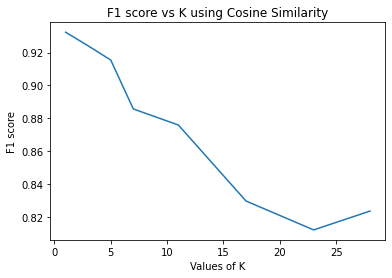

In [14]:
f1 = []
for k in k_values:
    f1.append(f1_score[k])

plt.plot(k_values, f1)
plt.xlabel('Values of K')
plt.ylabel('F1 score')
plt.title('F1 score vs K using Cosine Similarity')
plt.show()

In [15]:
print('KNN results using Euclidean Distance on Validation Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_valid, y_valid, k_values, euclidean_distance)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Euclidean Distance on Validation Dataset
+-----+------------+-------------+-----------+------------+----------------------+
|   K |   Accuracy |   Precision |    Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+===========+============+======================+
|   1 |   0.949731 |    0.978261 | 0.625     |  0.762712  | [[484, 1], [27, 45]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   3 |   0.931777 |    0.972222 | 0.486111  |  0.648148  | [[484, 1], [37, 35]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   5 |   0.917415 |    1        | 0.361111  |  0.530612  | [[485, 0], [46, 26]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   7 |   0.903052 |    1        | 0.25      |  0.4       | [[485, 0], [54, 18]] |
+-----+------------+-------------+-----------+------------+----------------------+
|  11 |   0.888689 |    1   

The best results are produced at k=1, so we should use k=1 for our test data.

In [16]:
print('KNN results using Euclidean Distance on Test Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_test, y_test, k_values, euclidean_distance)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Euclidean Distance on Test Dataset
+-----+------------+-------------+-----------+------------+----------------------+
|   K |   Accuracy |   Precision |    Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+===========+============+======================+
|   1 |   0.960573 |    1        | 0.714286  |   0.833333 | [[481, 0], [22, 55]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   3 |   0.935484 |    0.976744 | 0.545455  |   0.7      | [[480, 1], [35, 42]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   5 |   0.928315 |    1        | 0.480519  |   0.649123 | [[481, 0], [40, 37]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   7 |   0.917563 |    1        | 0.402597  |   0.574074 | [[481, 0], [46, 31]] |
+-----+------------+-------------+-----------+------------+----------------------+
|  11 |   0.899642 |    1        |

As earlier predicted that we should use k=1 for test dataset. So here also on test dataset best results occured on k=1

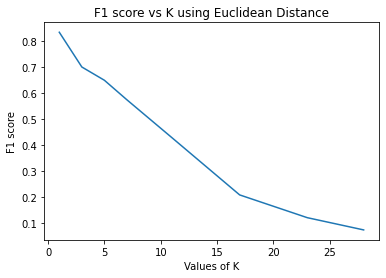

In [17]:
f1 = []
for k in k_values:
    f1.append(f1_score[k])

plt.plot(k_values, f1)
plt.xlabel('Values of K')
plt.ylabel('F1 score')
plt.title('F1 score vs K using Euclidean Distance')
plt.show()

In [18]:
print('KNN results using Manhattan Distance on Validation Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_valid, y_valid, k_values, manhattan_distance)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Manhattan Distance on Validation Dataset
+-----+------------+-------------+-----------+------------+----------------------+
|   K |   Accuracy |   Precision |    Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+===========+============+======================+
|   1 |   0.949731 |    0.958333 | 0.638889  |  0.766667  | [[483, 2], [26, 46]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   3 |   0.933573 |    1        | 0.486111  |  0.654206  | [[485, 0], [37, 35]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   5 |   0.917415 |    1        | 0.361111  |  0.530612  | [[485, 0], [46, 26]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   7 |   0.908438 |    1        | 0.291667  |  0.451613  | [[485, 0], [51, 21]] |
+-----+------------+-------------+-----------+------------+----------------------+
|  11 |   0.897666 |    1   

The best results are produced at k=1, so we should use k=1 for our test data.

In [19]:
print('KNN results using Manhattan Distance on Test Dataset')
accuracy,precision,recall,f1_score,confusion_matrix = fxn(x_train, y_train, x_test, y_test, k_values, manhattan_distance)

data = []
for k in k_values:
    data.append([k,accuracy[k],precision[k],recall[k],f1_score[k],confusion_matrix[k]])

head = ['K', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
print(tabulate(data, headers=head, tablefmt="grid"))

KNN results using Manhattan Distance on Test Dataset
+-----+------------+-------------+-----------+------------+----------------------+
|   K |   Accuracy |   Precision |    Recall |   F1 Score | Confusion Matrix     |
+=====+============+=============+===========+============+======================+
|   1 |   0.962366 |    1        | 0.727273  |   0.842105 | [[481, 0], [21, 56]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   3 |   0.939068 |    0.977778 | 0.571429  |   0.721311 | [[480, 1], [33, 44]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   5 |   0.9319   |    1        | 0.506494  |   0.672414 | [[481, 0], [38, 39]] |
+-----+------------+-------------+-----------+------------+----------------------+
|   7 |   0.921147 |    1        | 0.428571  |   0.6      | [[481, 0], [44, 33]] |
+-----+------------+-------------+-----------+------------+----------------------+
|  11 |   0.908602 |    1        |

As earlier predicted that we should use k=1 for test dataset. So here also on test dataset best results occured on k=1

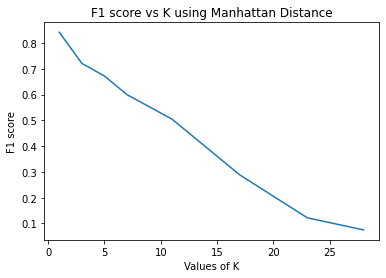

In [20]:
f1 = []
for k in k_values:
    f1.append(f1_score[k])

plt.plot(k_values, f1)
plt.xlabel('Values of K')
plt.ylabel('F1 score')
plt.title('F1 score vs K using Manhattan Distance')
plt.show()

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance] and compare with the Cosine Similarity distance results.***

Answer: The experimentation is done above. The Cosine Similarity results are best out of all distance measures used. 

The order being Cosine Similarity > Manhattan Distance > Euclidean Distance

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

Answer: Cosine Similarity distance measure works best for the problem, because the text in emails is representated as a high-dimensional vector and cosine similarity works best both for high dimensional data and recommendation systems.


### Euclidean Distance:

Pros:

-> Works nicely with low-dimensional data.

-> Should be used when magnitude of the vectors is important to be measured.

-> Simple to implement.

Cons:

-> Scale in-variant :- distances can be skewed depending on the units of the features. Normalization of data needs to be done before using this distance measure.

-> Curse of Dimensionality :- As the dimensionality increases, euclidean distance becomes less useful, due to the notion that higher-dimensional space does not act as we would, intuitively, expect from 2- or 3-dimensional space.

### Cosine Similarity:

Pros:

-> Works well with high dimensional data and is used as a counteract to Euclidean.

-> Measure of orientation is more important here than order of magnitude.

Cons:

-> Magnitude of vectors is not taken into account, merely their direction.

### Manhattan Distance:

Pros:

-> Works well when the dataset has discrete or binary attributes.

Cons:

-> Works okay for high dimensional data and is more likely to give a higher distance value than euclidean distance since it does not use shortest path possible. One needs to take this into account when considering to choose manhattan as a distance metric.



### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

As the best result is produced by using cosine similarity as metric, so we are using cosine similarity as a metric in sklearn's KNN classifier. Also the best result occur for k=1 so we are using value of k as 1 here.

In [21]:
# splitting the data to be used by in-built sklearn's classifier
x = df['vector']
y = df['label']

x_train_new = []
y_train_new = []
x_valid_new = []
y_valid_new = []
x_test_new = []
y_test_new = []

for key in x_train.keys():
    x_train_new.append(df['vector'][key])
    y_train_new.append(df['label'][key])

for key in x_valid.keys():
    x_valid_new.append(df['vector'][key])
    y_valid_new.append(df['label'][key])

for key in x_test.keys():
    x_test_new.append(df['vector'][key])
    y_test_new.append(df['label'][key])

In [22]:
def cosine_sim(vec1, vec2):
    dot = 0.0
    sq1 = 0.0
    sq2 = 0.0
    for i in range(len(vec1)):
        dot += (vec1[i]*vec2[i])
        sq1 += (vec1[i]**2)
        sq2 += (vec2[i]**2)

    sq = math.sqrt(sq1*sq2)
    cos_sim = dot/sq
    sin_sim = 1 - (cos_sim**2)

    if sin_sim < 0.0:
        return 1.0
    else:
        return math.sqrt(sin_sim)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# write the hyper-parameter here  --> by default the in-built KNN classifier uses euclidean distance as a metric to compare the similarity 
k = 1
model = KNeighborsClassifier(n_neighbors=k,metric='cosine')

# Train the model using the training sets
model.fit(x_train_new,y_train_new)

#Predict Output
predicted = model.predict(x_valid_new) 

# Calculating accuracy, precision, recall, f1 score, confusion matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score 
accuracy = accuracy_score(y_valid_new, predicted, normalize=True, sample_weight=None)
recall = recall_score(y_valid_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
precision = precision_score(y_valid_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
f1_score = f1_score(y_valid_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
confusion_matrix = confusion_matrix(y_valid_new, predicted)

print('Results of built-in KNN classifier on Validation Dataset')
print('For k: {},  accuracy: {},  precision: {}  recall: {}  f1 score: {}  confusion matrix: {}'.format(k,accuracy,precision,recall,f1_score,confusion_matrix))

print('----------------------------------------')

#Predict Output
predicted = model.predict(x_test_new) 

# Calculating accuracy, precision, recall, f1 score, confusion matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score 
accuracy = accuracy_score(y_test_new, predicted, normalize=True, sample_weight=None)
recall = recall_score(y_test_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
precision = precision_score(y_test_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
f1_score = f1_score(y_test_new, predicted, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
confusion_matrix = confusion_matrix(y_test_new, predicted)

print('Results of built-in KNN classifier on Test Dataset')
print('For k: {},  accuracy: {},  precision: {}  recall: {}  f1 score: {}  confusion matrix: {}'.format(k,accuracy,precision,recall,f1_score,confusion_matrix))

Results of built-in KNN classifier on Validation Dataset
For k: 1,  accuracy: 0.9640933572710951,  precision: 0.9193548387096774  recall: 0.7916666666666666  f1 score: 0.8507462686567164  confusion matrix: [[480   5]
 [ 15  57]]
----------------------------------------
Results of built-in KNN classifier on Test Dataset
For k: 1,  accuracy: 0.967741935483871,  precision: 0.8734177215189873  recall: 0.8961038961038961  f1 score: 0.8846153846153846  confusion matrix: [[471  10]
 [  8  69]]


***Compare both the models result.***

The results from both the models are almost the same as expected.

***What is the time complexity of training using KNN classifier?***

The Time Complexity of training using KNN classifier is O(1) because KNN is a lazy leraning classifier which means that there is no need for learning or training of the model and all of the data points are used at the time of prediction.

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

The Time Complexity while testing is O(n*d) if we are testing for one test point, where
n is the number of training data points
d is the dimension of vector of each training data point.

For m testing points, the time complexity would become O(n * m * d).

KNN is a non-linear classifier. The decision boundaries of KNN are locally linear segments, but in general have a complex shape that is not equivalent to a line in 2D or a hyperplane in higher dimensions. It can learn any(both linear and non-linear) boundaries.